In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.style.use('ggplot')

In [106]:
DATA_DIRECTORY = 'dataset/csv'

aisles = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'aisles.csv')
    )

departments = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'departments.csv')
    )

order_products_prior = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'order_products__prior.csv')
    )
orders = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'orders.csv')
    )

products = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'products.csv')
                       )


dfs = {"Aisles": aisles, "Departments":departments, "Order Products" : order_products_prior, "Orders": orders, "Products" :products}

In [107]:
for title, df in dfs.items():
    print(title)
    print(df.shape)
    print(f"Missing values: \n{df.isna().sum()}")
    display(df.head())
    print('\n\n')

Aisles
(134, 2)
Missing values: 
aisle_id    0
aisle       0
dtype: int64


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation





Departments
(21, 2)
Missing values: 
department_id    0
department       0
dtype: int64


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol





Order Products
(32434489, 4)
Missing values: 
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0





Orders
(3421083, 7)
Missing values: 
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0





Products
(49688, 4)
Missing values: 
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [108]:
days = ['Sunday','Monday','Tuesday','Wednesday','Thursay','Friday','Saturday']
orders['order_dow'] = orders['order_dow'].replace([0,1,2,3,4,5,6], days)
orders['order_dow'] = pd.Categorical(orders['order_dow'], categories=days, ordered=True)

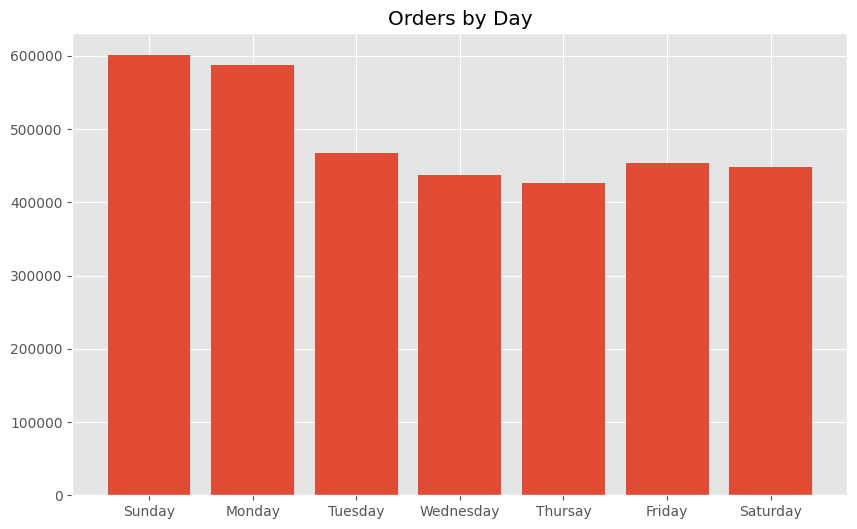

In [109]:
# Orders by Day
plt.figure(figsize=(10,6))
plt.title('Orders by Day')
plt.bar(height = orders.groupby('order_dow')['order_number'].count(), x=days)
plt.show()


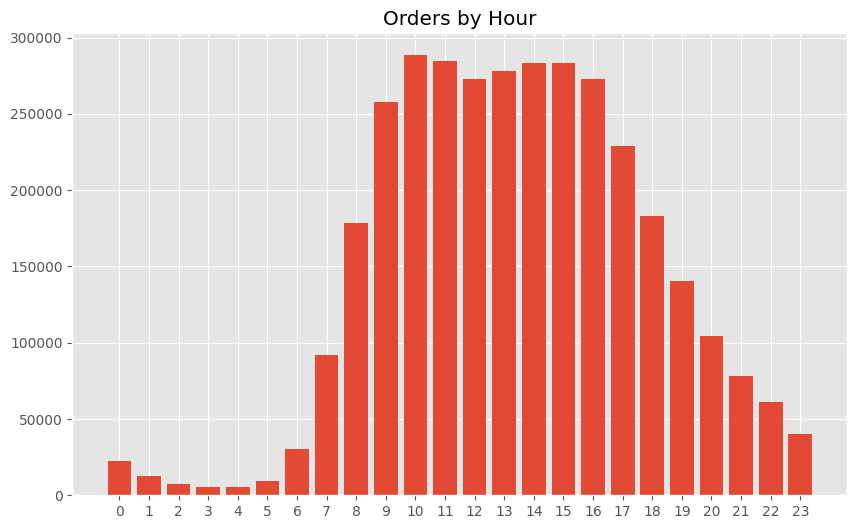

In [110]:
# Orders by Hour
plt.figure(figsize=(10,6))
plt.title('Orders by Hour')
plt.bar(height = orders.groupby('order_hour_of_day')['order_number'].count(), x=range(0,24))
plt.xticks(range(0,24))
plt.show()


> *We see some strong trends of people prefering to make orders early on during the week and between 9am-5pm*

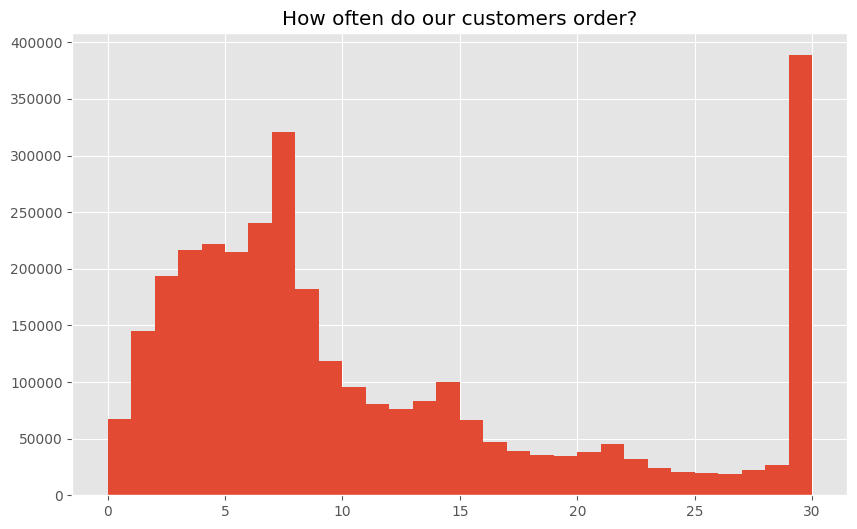

In [111]:
# How often do our customers order?
plt.figure(figsize=(10,6))
plt.title('How often do our customers order?')
plt.hist(data=orders, x='days_since_prior_order', bins=30)
plt.show()

> clearly a bimodal distribution, meaning we probably have atleast 2 underlying groups in this data that we could split on. <br> We could use a clustering algorithm to find the underlying groups and use that information for target marketing.

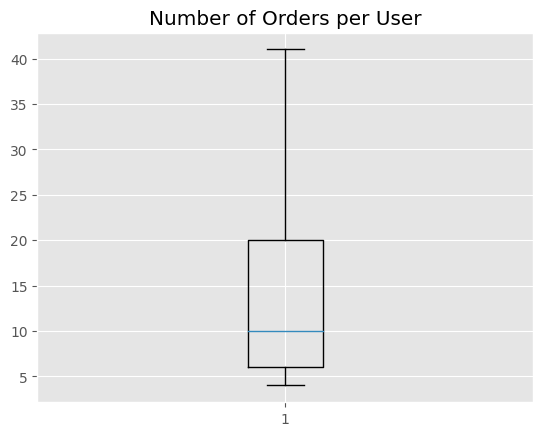

In [112]:
# How many orders do our customers make?
plt.boxplot(orders.groupby('user_id')['order_number'].count(), showfliers=False)
plt.title('Number of Orders per User')
plt.show()

> Outliers have been removed to make a simpler and easier box plot to read. <br>
> We see 50% of our customers have made between 6 - 20 orders, over 75% have ordered more than 5 times and the median customer has made around 10 orders.

In [113]:
# What are our best sellers?
product_counts = order_products_prior['product_id'].value_counts().reset_index()
# normalize the counts
product_prop = order_products_prior['product_id'].value_counts(normalize=True).reset_index()
product_prop['proportion'] = product_prop['proportion'].apply(lambda x: f"{round(x*100,2)}%")
# join our fact and dimension table to get the product names

# join our 2 tables with the product name dimension table
top_10_prod = product_counts.join(product_prop.join(products.set_index('product_id'), on='product_id').set_index('product_id'), on='product_id')[['product_name', 'count','proportion']].head(10)
top_10_prod


,product_name,count,proportion
0,Banana,472565,1.46%
1,Bag of Organic Bananas,379450,1.17%
2,Organic Strawberries,264683,0.82%
3,Organic Baby Spinach,241921,0.75%
4,Organic Hass Avocado,213584,0.66%
5,Organic Avocado,176815,0.55%
6,Large Lemon,152657,0.47%
7,Strawberries,142951,0.44%
8,Limes,140627,0.43%
9,Organic Whole Milk,137905,0.43%


In [114]:
# How often do people order the same items again?
round(order_products_prior['reordered'].sum() / order_products_prior['reordered'].count(), 2)


0.59

> 59% of the items ordered have been ordered before

In [115]:
# What is the most reordered product?
total_order = order_products_prior['product_id'].value_counts().reset_index()

# include only items ordered more than 50 times
total_order = total_order[total_order['count'] > 50]
reordered_products = order_products_prior.groupby('product_id')['reordered'].sum().reset_index()
# join or 2 tables on product_id
reordered_products = total_order.join(reordered_products.set_index('product_id'), on='product_id', how='left')
reordered_products['reordered_ratio'] = reordered_products['reordered'] / reordered_products['count']
reordered_products['reordered_ratio'] = reordered_products['reordered_ratio'].apply(lambda x: round(x, 2))
reordered_products = reordered_products.join(products.set_index('product_id'), on='product_id').sort_values('reordered_ratio', ascending=False)[['product_name', 'reordered_ratio', 'count']].head(10)
reordered_products

,product_name,reordered_ratio,count
23623,Raw Veggie Wrappers,0.94,68
21269,Serenity Ultimate Extrema Overnight Pads,0.93,87
19963,Chocolate Love Bar,0.92,101
20013,Maca Buttercups,0.90,100
24720,Sparking Water,0.90,60
23704,Bars Peanut Butter,0.90,67
23869,Soy Crisps Lightly Salted,0.89,66
20411,Organic Blueberry B Mega,0.89,96
19102,Benchbreak Chardonnay,0.89,111
19036,Thousand Island Salad Snax,0.88,112


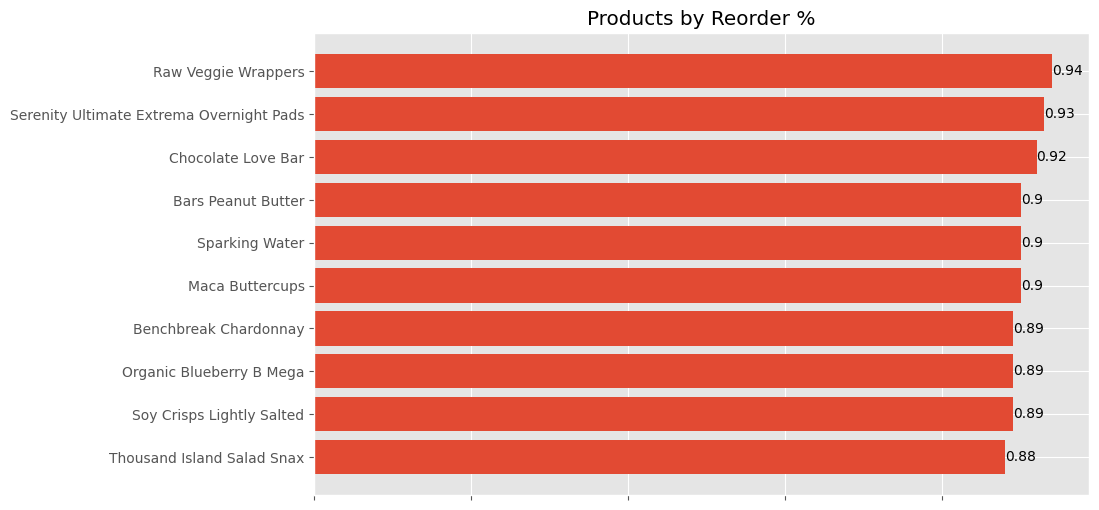

In [116]:
reordered_products.sort_values('reordered_ratio', ascending=True, inplace=True)
plt.figure(figsize=(10,6))
barplot = plt.barh(width = reordered_products['reordered_ratio'], y = reordered_products['product_name'])
plt.bar_label(barplot)
plt.title('Products by Reorder %')
plt.tick_params(labelbottom=False)
plt.show()

In [117]:
# What item do customers buy first

first_orders = order_products_prior.value_counts(['product_id','add_to_cart_order']).reset_index()
first_orders = first_orders[first_orders['add_to_cart_order'] == 1]
first_orders = first_orders.join(product_counts.set_index('product_id'), on='product_id', lsuffix='_first', rsuffix='_total')
first_orders['first_order_pct'] = first_orders['count_first'] / first_orders['count_total']
first_orders = first_orders[first_orders['count_total'] > 50]

first_orders = first_orders[['product_id', 'first_order_pct']].join(products.set_index('product_id'), on='product_id')[['product_name', 'first_order_pct']].sort_values(by='first_order_pct').tail(10)
first_orders

,product_name,first_order_pct
84900,Thousand Island Salad Snax,0.508929
133747,V Fusion Strawberry Banana 100% Vegetable & Fr...,0.516129
121189,Crisp White,0.537313
142563,Total Comfort Powder Baby Formula,0.557692
107091,Advance Organic Powder,0.558442
91483,Lemon Ice Cubes,0.597701
71373,Alimentum Infant Formula,0.630631
91585,Laxative Tablets,0.650000
95008,"Flavored Vodka, Peach",0.704225
92964,Rehab Energy Iced Tea Orangeade,0.784615


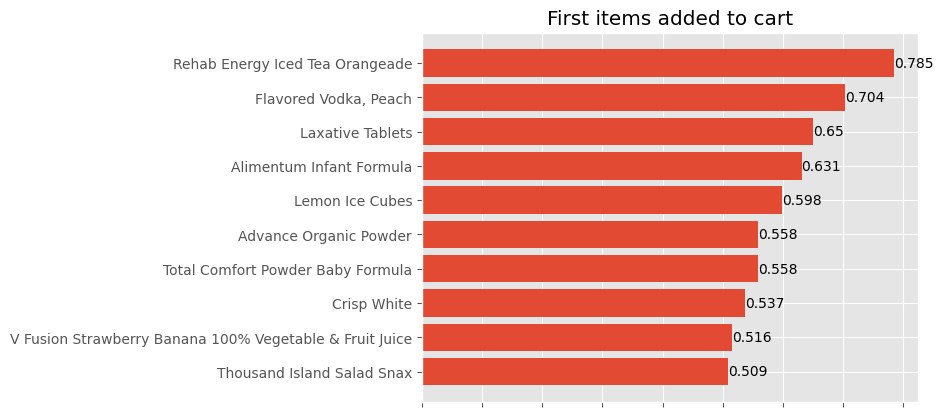

In [118]:
barplot = plt.barh(width = round(first_orders['first_order_pct'],3), y = first_orders['product_name'])
plt.bar_label(barplot)
plt.title('First items added to cart')
plt.tick_params(labelbottom=False)
plt.show()

> Almost 80% of the time the Rehad Energy Iced Tea is bought, it is added into the cart first

In [119]:
# department reorder ratio
# isle reorder ratio

# pct of users orders by department
 

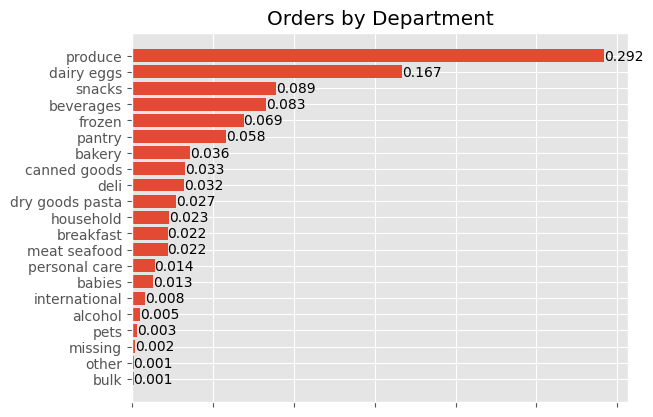

In [120]:
department_orders = order_products_prior.join(products[['product_id','department_id']].set_index('product_id'), on='product_id').value_counts('department_id', normalize=True).reset_index()
department_orders = department_orders.join(departments.set_index('department_id'), on='department_id')[['department','proportion']]
department_orders = department_orders.sort_values(by='proportion')

barplot = plt.barh(width = round(department_orders['proportion'],3), y = department_orders['department'])
plt.bar_label(barplot)
plt.title('Orders by Department')
plt.tick_params(labelbottom=False)
plt.show()

> by far the most common department is produce. Almost 30% of units ordered are from this department, note that this is ranked by units and most likely due to buying many small products, aposed to single more expensive products from departments such as  personal care and pets.

In [121]:
department_orders = order_products_prior.join(products[['product_id','department_id']].set_index('product_id'), on='product_id').value_counts('department_id').reset_index()
department_reorders = order_products_prior.groupby('product_id').sum().reset_index()[['product_id', 'reordered']]
department_reorders = department_reorders.join(products[['product_id','department_id']].set_index('product_id'), on='product_id').groupby('department_id').sum().reset_index()[['department_id','reordered']]


In [126]:
department_orders = department_orders.join(department_reorders.set_index('department_id'), on='department_id')
department_orders['reorder_pct'] = department_orders['reordered'] / department_orders['count']

In [127]:
department_orders = department_orders.join(departments.set_index('department_id'), on='department_id')[['department','reorder_pct']].sort_values(by='reorder_pct')

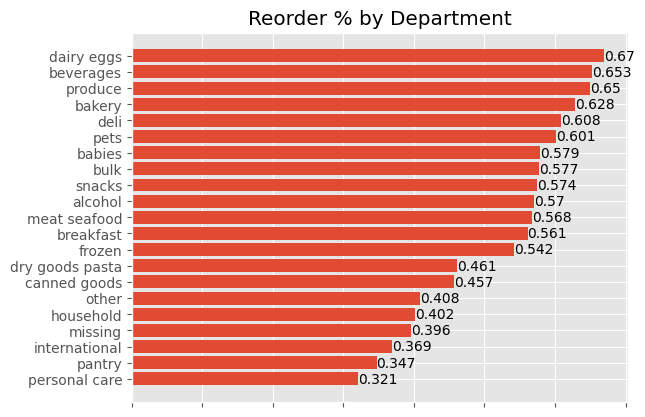

In [128]:
barplot = plt.barh(width = round(department_orders['reorder_pct'],3), y = department_orders['department'])
plt.bar_label(barplot)
plt.title('Reorder % by Department')
plt.tick_params(labelbottom=False)
plt.show()

> As expected, the product that are fresh/frequently used are re ordered the most.